# Mapping network graph to 3D space.

Example notebook showing how to map a networkX to 3D Space. 

**Demo code only. Not supported in any way.**

~ Simon O'Doherty. 

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from math import cos, sin, pi, sqrt

# https://k3d-jupyter.org/
import k3d  # This only works in jupyter. If you solve for Watson Studio/Pycharm let me know. :) 
import numpy as np

Start by loading the data and building the network graph. For the demo I'm using the catalog intents from Watson Assistant general section. 

The structure will be: 

    [root] -> [intent name] -> [question text]
    
The intents will be given a size attribute that matches number of questions associated with it. This will be used to generate the sphere in 3D.

In [2]:
df = pd.read_csv('intents.csv', names=['question', 'intent'])

G = nx.DiGraph()

for index, row in df.iterrows():
    G.add_edge("Intent",row['intent'],weight=5)
    G.add_edge(row['intent'], row['question'], weight=3)
    
    size = len(df.query('intent == "{}"'.format(row['intent'])))
    G.add_node(row['intent'], size=size)

## 2D Network generated. 

Very messy. 

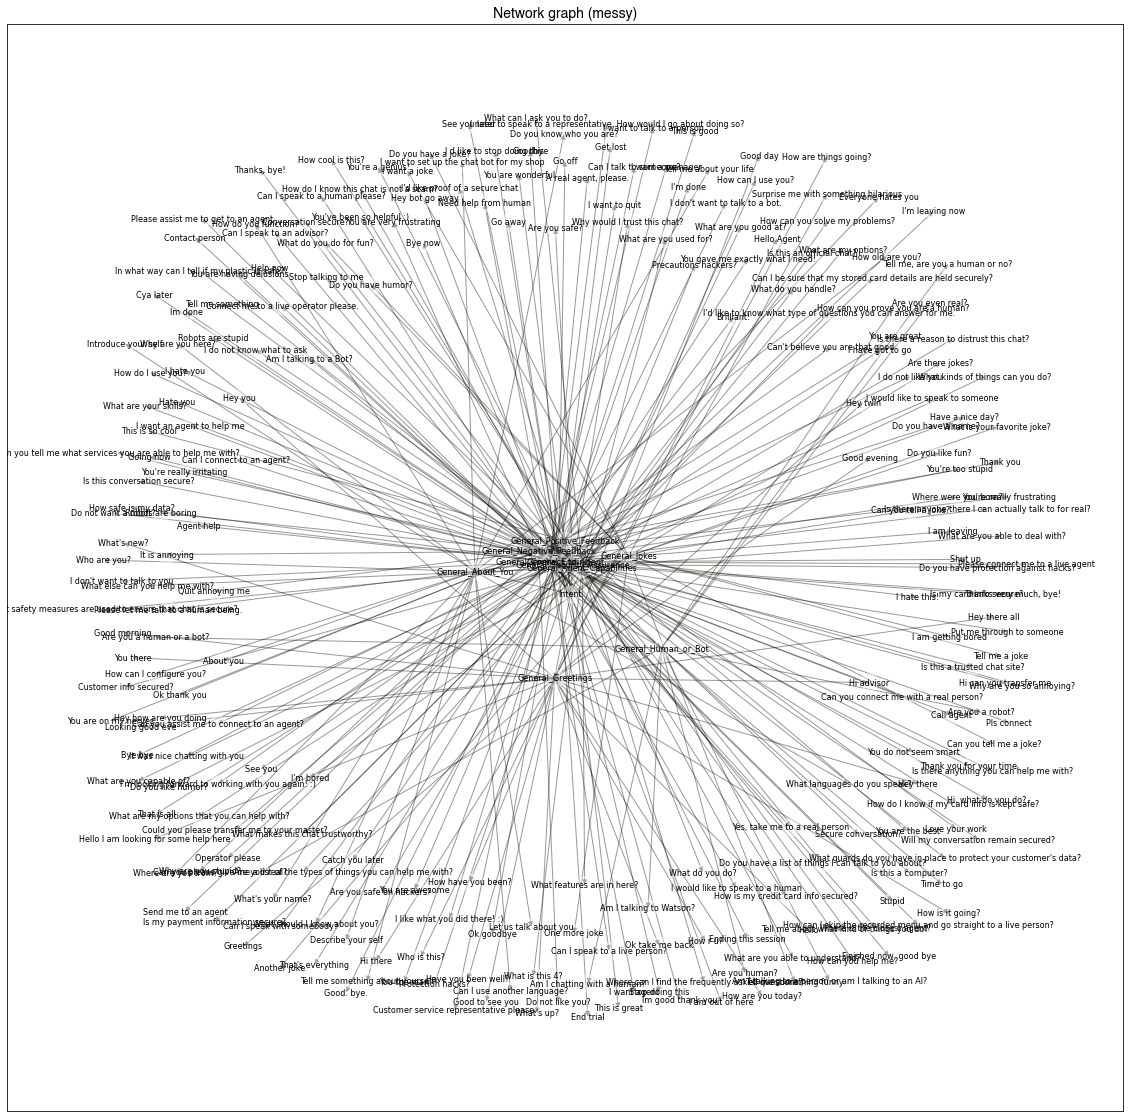

In [3]:
pos = nx.spring_layout(G, iterations=20)
plt.figure(figsize=(20, 20))
plt.rcParams['figure.dpi'] = 300
nx.draw_networkx_edges(G, pos, alpha=0.3, width=1, edge_color="ivory")
nx.draw_networkx_nodes(G, pos, node_color="w", alpha=0.4)
nx.draw_networkx_edges(G, pos, alpha=0.4, node_size=0, width=1, edge_color="k")
nx.draw_networkx_labels(G, pos, font_size=8)
font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
_ = plt.title("Network graph (messy)", font)


## Building 3D network graph. 

Set up your defaults for the rendering. 

In [4]:
# Scaling allows to create different size spheres to map nodes onto. 
scale_intents = 8.0
scale_questions = 1.0

point_size = 0.05

root_node_color = 0xff0000
root_edge_color = 0x00ff00
root_edge_width = 0.002

intent_node_color = 0xff00ff
intent_text_color = 0xffffff   # Other text paramaters, change code. 
intent_mode = 'local'          # dynamic, local, side. 
intent_edge_color = 0x00ffff
intent_edge_width = 0.002

question_node_color = 0xffff00
question_text_color = 0x80ff80
question_mode = 'local'

# Render quality. 
shader = '3d'

This next piece of code maps a group of points evenly on a sphere. With the ability to scale the spheres. As we will have spheres sitting in spheres. 

More information can be found here: https://stackoverflow.com/a/16128461/1167890

In [5]:
def GetPointsEquiAngularlyDistancedOnSphere(numberOfPoints=45, scale=1.0, root=(0,0,0)):
    dlong = pi*(3.0-sqrt(5.0))
    dz = 2.0/numberOfPoints
    long = 0.0
    z = 1.0 - dz/2.0
    ptsOnSphere =[]
    for k in range( 0, numberOfPoints): 
        r = sqrt(scale - z*z)
        ptNew = (cos(long)*r, sin(long)*r, z)
        
        ptsOnSphere.append( tuple(map(lambda i, j: i + j, ptNew, root))  )
        z = z - dz
        long = long + dlong
    return ptsOnSphere

Generate objects in 3D space.

In [8]:
plot = k3d.plot(name='Network Graph in 3D Space')

total_intents = df['intent'].nunique()
eintents = enumerate(df['intent'].unique().tolist())

# Create nodes for intents in the sphere. 
nodes3d = GetPointsEquiAngularlyDistancedOnSphere(total_intents, scale=scale_intents)

# Root node.
root_node = [(0,0,0)]
plot += k3d.points(positions=root_node, point_size=point_size, color=root_node_color, name='Intent', shader=shader)

# Intent Labels + lines.
for index, text in eintents:
    plot += k3d.line([root_node[0], nodes3d[index]], color=root_edge_color, width=root_edge_width, shader=shader, name='') # name=f'root->{text}')

    plot += k3d.points(positions=nodes3d[index], point_size=point_size, color=intent_node_color, name=text)

    plot += k3d.label(text, position=nodes3d[index], mode=intent_mode,
                      color=intent_text_color, on_top=True, size=1.0, 
                      label_box=False, is_html=True)
    
    # Next the questions.
    questions = df.query(f'intent == "{text}"')['question'].unique().tolist()
    qpoints = GetPointsEquiAngularlyDistancedOnSphere(len(questions), scale=scale_questions, root=nodes3d[index])
    
    for qidx, question in enumerate(questions):
        plot += k3d.line([nodes3d[index], qpoints[qidx]], color=intent_edge_color, width=intent_edge_width, shader=shader, name='') # name=f'{text}->{question}')

        plot += k3d.points(positions=qpoints[qidx], point_size=point_size, color=question_node_color, name=question)

        # This is way too intensive to render. 
        # plot += k3d.label(question, position=qpoints[qidx], mode=question_mode,
        #                  color=question_text_color, on_top=True, size=1.0, 
        #                  label_box=False, is_html=True)

        
        
    


### Display network graph. 

Go get a coffee. ;) 

In [10]:
plot.shader=shader

plot.display()

Output()

If you have issues rendering. This is an example output. 

![Sample Image](sample.png)

There is also a generated interactive HTML File. 